# Optimal Cluster Count Grid Search 
This notebook demonstrates how to efficiently determine clustering parameters using distributed grid search. Data is distributed across nodes, clustering algorithms like `k-means`  are applied, and results are evaluated with metrics such as silhouette score to identify the best configuration

In [ ]:
import jax
import healpy as hp
import numpy as np

from furax.comp_sep import spectral_cmb_variance, get_clusters, optimize , negative_log_likelihood , spectral_log_likelihood

import jax.numpy as jnp

from furax._base.core import HomothetyOperator
from furax.landscapes import StokesPyTree
from functools import partial
import matplotlib.pyplot as plt



# Load Planck Galactic Masks  
This cell loads Planck Galactic masks (`GAL020`, `GAL040`, `GAL060`) for NSIDE 64 from a `.npz` file. These masks are used to exclude regions of the sky with Galactic contamination.

In [2]:
GAL020 = np.load('GAL_PlanckMasks_64.npz')['GAL020']
GAL040 = np.load('GAL_PlanckMasks_64.npz')['GAL040']
GAL060 = np.load('GAL_PlanckMasks_64.npz')['GAL060']

# Sky Component Simulation  
This cell defines parameters and simulates sky components (`cmb`, `dust`, `synchrotron`) for a specified NSIDE of 64. It generates random maps for each component in the `QU` Stokes parameterization across 15 frequency bands, with values ranging from 40 to 402 GHz. The sky maps are represented as instances of the `StokesPyTree` class.

In [3]:
nside = 64
npixel = 12 * nside**2
stokes_type = 'QU'
frequency_count = 15
nu = jnp.linspace(40.0, 402.0, frequency_count)

comp_keys = jax.random.split(jax.random.PRNGKey(0), 3)
stokes_cls = StokesPyTree.class_for(stokes_type)

sky = {
    'cmb': stokes_cls.normal(comp_keys[0], (npixel,)),
    'dust': stokes_cls.normal(comp_keys[1], (npixel,)),
    'synchrotron': stokes_cls.normal(comp_keys[2], (npixel,)),
}

# Masked Sky and Cluster Visualization  
This cell performs the following tasks:  
1. It extracts clusters of pixels from the `GAL020` mask for three sets of patches: `temp_dust`, `beta_dust`, and `beta_pl`—each with a specified number of clusters.  
2. The `get_cutout_from_mask` function is used to generate cutouts (sky maps) for each of the components (`cmb`, `dust`, `synchrotron`) and the patch indices (`temp_dust`, `beta_dust`, `beta_pl`).  

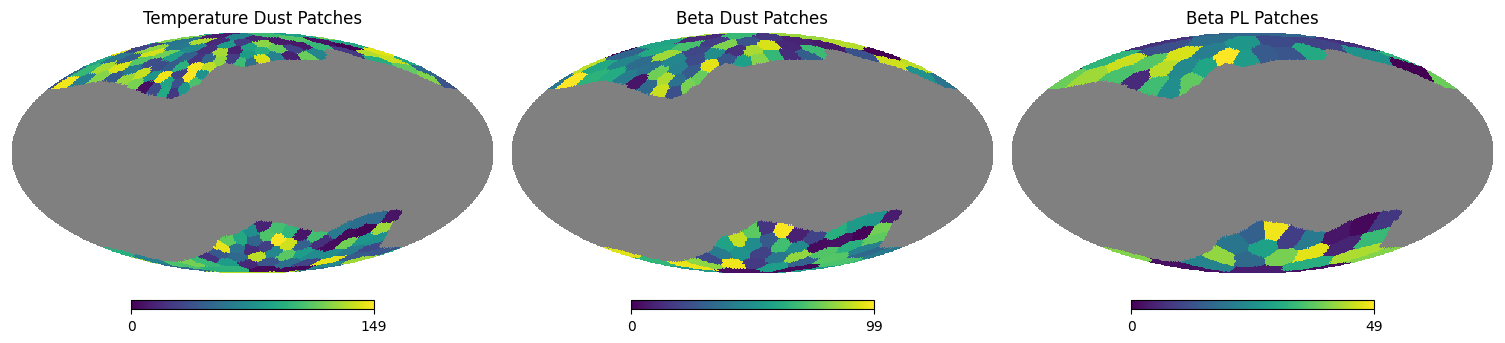

In [ ]:
temp_dust_patches_count = 150
beta_dust_patches_count = 100
beta_pl_patches_count = 50
max_centroids = 300
indices, = jnp.where(GAL020 == 1)

temp_dust_patch_indices = get_clusters(GAL020,
                                       indices,
                                       temp_dust_patches_count,
                                       jax.random.PRNGKey(0),
                                       max_centroids=max_centroids)
beta_dust_patch_indices = get_clusters(GAL020,
                                       indices,
                                       beta_dust_patches_count,
                                       jax.random.PRNGKey(0),
                                       max_centroids=max_centroids)
beta_pl_patch_indices = get_clusters(GAL020,
                                     indices,
                                     beta_pl_patches_count,
                                     jax.random.PRNGKey(0),
                                     max_centroids=max_centroids)

params = {
    'temp_dust': jnp.linspace(10.0, 30.0, temp_dust_patches_count),
    'beta_dust': jnp.linspace(1.5, 2.5, beta_dust_patches_count),
    'beta_pl': jnp.linspace(-3.0, -2.0, beta_pl_patches_count),
}

patch_indices = {
    'temp_dust_patches': temp_dust_patch_indices,
    'beta_dust_patches': beta_dust_patch_indices,
    'beta_pl_patches': beta_pl_patch_indices,
}



@jax.jit
def get_cutout_from_mask(ful_map, indices):
    return jnp.take(ful_map, indices)


@jax.jit
def from_cutout_to_fullmap(goodpix, indices, ful_map):
    return ful_map.at[indices].set(goodpix)


(indices, ) = jnp.where(GAL020 == 1)

masked_sky = jax.tree.map(
    lambda full_map: get_cutout_from_mask(full_map, indices), sky)
masked_clusters = jax.tree.map(
    lambda full_map: get_cutout_from_mask(full_map, indices).astype(jnp.int32),
    patch_indices)


# Set up subplots
fig = plt.figure(figsize=(15, 5))
# Plot each map
hp.mollview(temp_dust_patch_indices,
            title='Temperature Dust Patches',
            sub=(1, 3, 1))
hp.mollview(beta_dust_patch_indices, title='Beta Dust Patches', sub=(1, 3, 2))
hp.mollview(beta_pl_patch_indices, title='Beta PL Patches', sub=(1, 3, 3))

# Display the plot
plt.show()

# Simulate Mixed Sky Data  
Simulate mixed sky data `d` using optimal parameters and cluster configurations. 

In [8]:
from generate_maps import simulate_D_from_params

dust_nu0 = 150.0
synchrotron_nu0 = 20.0

spectral_cmb_variance = partial(spectral_cmb_variance,
                                dust_nu0=dust_nu0,
                                synchrotron_nu0=synchrotron_nu0)
negative_log_likelihood = partial(negative_log_likelihood,
                                  dust_nu0=dust_nu0,
                                  synchrotron_nu0=synchrotron_nu0)

spectral_log_likelihood = partial(spectral_log_likelihood,
                                    dust_nu0=dust_nu0,
                                    synchrotron_nu0=synchrotron_nu0)

d = simulate_D_from_params(
    params,
    masked_clusters,
    nu,
    masked_sky,
    stokes_type,
    dust_nu0=dust_nu0,
    synchrotron_nu0=synchrotron_nu0,
)

N = HomothetyOperator(jnp.ones(1), _in_structure=d.structure)

# Defining Objective Function  
Define the objective function for optimizing sky data by minimizing variance.  
The `compute_minum_variance` function computes the optimal parameters based on Planck mask clusters and spectral data.


In [ ]:
import optax
import lineax as lx
from furax._base.core import Config
from functools import partial

solver = optax.lbfgs()

inverser_options = {'solver': lx.CG(rtol=1e-6, atol=1e-6, max_steps=100000), 'solver_throw': False}


(indices,) = jnp.where(GAL020 == 1)


@partial(jax.jit, static_argnums=(5))
def compute_minimum_variance(T_d_patches, B_d_patches, B_s_patches, planck_mask, indices , max_patches=25):
    temp_dust_patch_indices = get_clusters(planck_mask, indices,T_d_patches, jax.random.PRNGKey(0),max_centroids=max_patches)
    beta_dust_patch_indices = get_clusters(planck_mask,indices, B_d_patches, jax.random.PRNGKey(0),max_centroids=max_patches)
    beta_pl_patch_indices = get_clusters(planck_mask, indices,B_s_patches, jax.random.PRNGKey(0),max_centroids=max_patches)

    params = {
        'temp_dust': jnp.linspace(15.0, 22.0, max_patches),
        'beta_dust': jnp.linspace(1.5, 2.5, max_patches),
        'beta_pl': jnp.linspace(-3.0, -2.0, max_patches),
    }

    patch_indices = {
        'temp_dust_patches': temp_dust_patch_indices,
        'beta_dust_patches': beta_dust_patch_indices,
        'beta_pl_patches': beta_pl_patch_indices,
    }
    masked_clusters = jax.tree.map(
        lambda full_map: get_cutout_from_mask(full_map, indices).astype(jnp.int32), patch_indices
    )

    with Config(**inverser_options):
        final_params, final_state = optimize(
            params,
            negative_log_likelihood,
            solver,
            max_iter=500,
            tol=1e-8,
            verbose=False,
            nu=nu,
            N=N,
            d=d,
            patch_indices=masked_clusters,
        )




    last_L = negative_log_likelihood(final_params, nu=nu, d=d, N=N, patch_indices=masked_clusters)

    return spectral_cmb_variance(final_params, nu=nu, d=d, N=N, patch_indices=masked_clusters)


bad_var = compute_minum_variance(10, 20, 25, GAL020,indices, max_patches=max_centroids)

# Compute Best Variance  
Compute the best variance using the optimal number of patches for temperature dust, beta dust, and beta PL patches, based on the Planck mask and cluster indices.


In [12]:
best_var = compute_minum_variance(temp_dust_patches_count, beta_dust_patches_count, beta_pl_patches_count, GAL020,indices, max_patches=max_centroids)

# Comparison of Variances  
The best variance (`best_var`) is lower than the bad variance (`bad_var`), indicating that the configuration with the optimal number of patches yields a better fit.


In [28]:
print(f"best_var < bad_var : {best_var < bad_var}")
print(f"best_var : {best_var}")
print(f"bad_var : {bad_var}")

best_var < bad_var : True
best_var : 1.9717915507579646
bad_var : 3.2557201302100234


In [ ]:
%load_ext autoreload
%autoreload 2
from furax.comp_sep import DistributedGridSearch

@jax.jit
def objective_function(T_d_patches, B_d_patches, B_s_patches):
    return compute_minum_variance(T_d_patches, B_d_patches, B_s_patches, GAL020,indices, max_patches=max_centroids)


# Put the good values for the grid search
search_space = {
    'T_d_patches': jnp.arange(10, 300, 140),
    'B_d_patches': jnp.arange(10, 300, 140),
    'B_s_patches': jnp.arange(10, 300, 140),
}

grid_search = DistributedGridSearch(
    objective_function, search_space, batch_size=2, progress_bar=True, log_every=0.1
)

results = grid_search.run()

for keys, values in results.items():
    print(f'{keys} : {values[0]}')